
Market Summary:

    Name Symbol Price (USD)    7d %     Volume (24h)         Market Cap
 Bitcoin    btc $115,729.00  -0.72%  $60,834,097,181 $2,303,821,014,869
Ethereum    eth   $3,664.09  -1.54%  $40,111,992,117   $442,441,872,737
     XRP    xrp       $2.99  -4.53%   $8,434,744,814   $177,517,639,738
  Tether   usdt       $1.00  -0.03% $109,453,091,910   $163,702,138,279
     BNB    bnb     $773.64  +0.33%   $2,199,895,993   $107,756,253,199
  Solana    sol     $169.24  -6.56%   $7,833,757,735    $91,216,380,911
    USDC   usdc       $1.00  -0.01%  $11,374,546,733    $63,995,912,982
Dogecoin   doge       $0.21 -10.33%   $2,856,754,735    $31,248,237,597


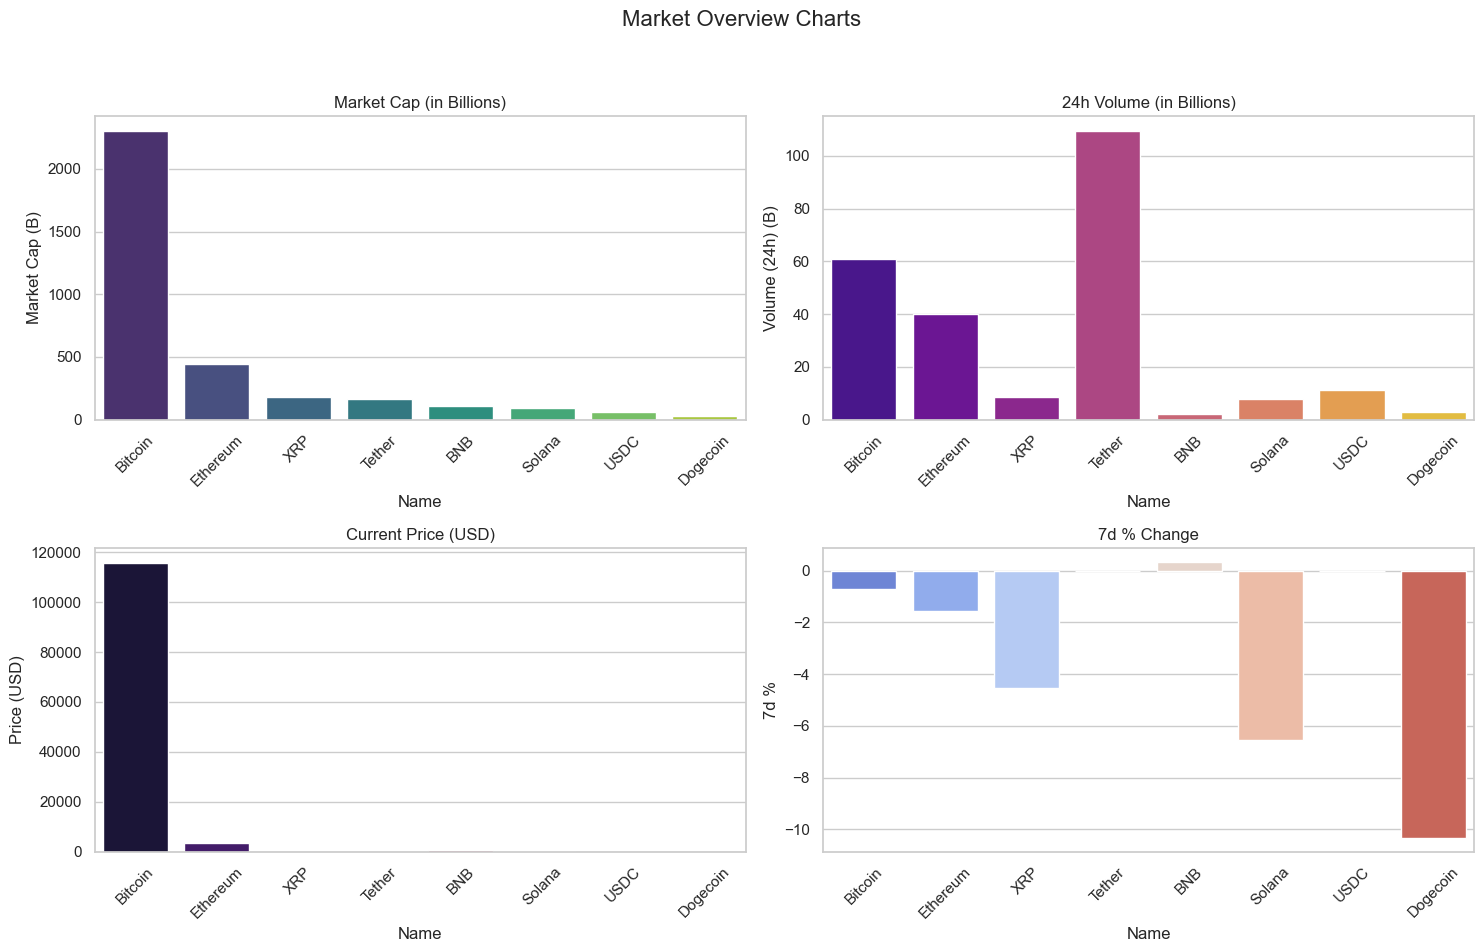


Available coins: bitcoin, ethereum, ripple, tether, binancecoin, solana, usd-coin, dogecoin


Enter a coin to view prediction + indicators (or type 'exit'):  bitcoin


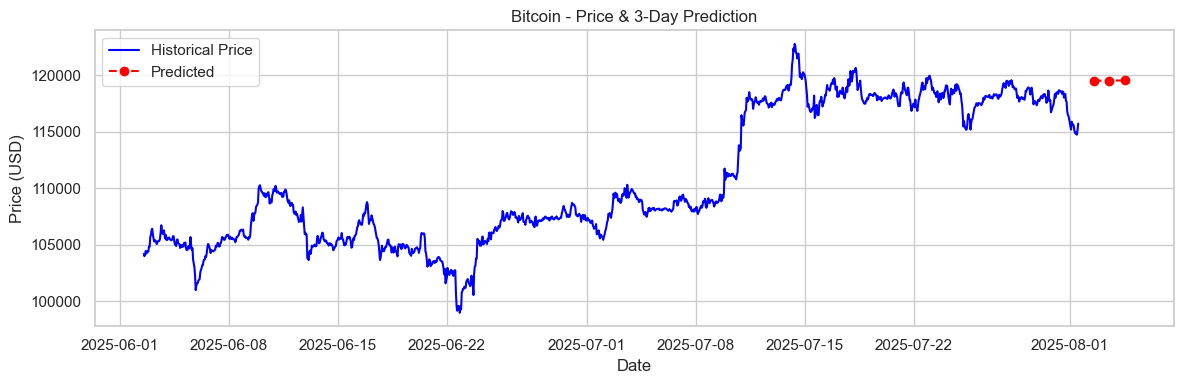

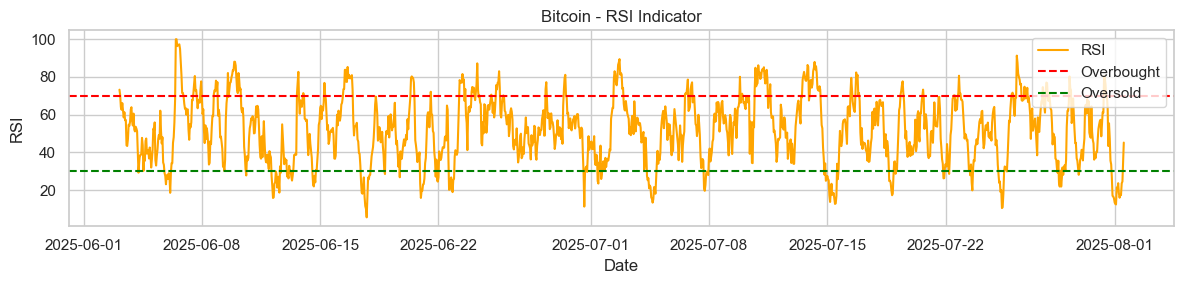

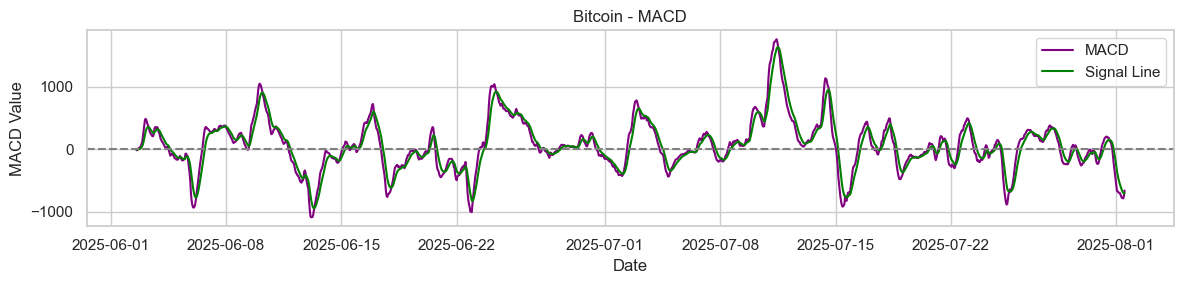


Available coins: bitcoin, ethereum, ripple, tether, binancecoin, solana, usd-coin, dogecoin


Enter a coin to view prediction + indicators (or type 'exit'):  exit


Exiting. Have a great day!


In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import time
import matplotlib

# ✅ Fix font warning by using emoji-friendly font
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# === CONFIG ===
COINS = [
    'bitcoin', 'ethereum', 'ripple', 'tether', 'binancecoin',
    'solana', 'usd-coin', 'dogecoin'
]
VS_CURRENCY = 'usd'

# === 1. Market Summary ===
def fetch_market_summary():
    url = 'https://api.coingecko.com/api/v3/coins/markets'
    params = {
        'vs_currency': VS_CURRENCY,
        'ids': ','.join(COINS),
        'order': 'market_cap_desc',
        'per_page': len(COINS),
        'page': 1,
        'sparkline': False,
        'price_change_percentage': '1h,24h,7d'
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    df = pd.DataFrame(data)
    df = df[[
        'name', 'symbol', 'current_price',
        'price_change_percentage_7d_in_currency',
        'total_volume', 'market_cap'
    ]]

    df.columns = [
        'Name', 'Symbol', 'Price (USD)', '7d %', 'Volume (24h)', 'Market Cap'
    ]

    return df

def display_market_summary(df):
    formatted_df = df.copy()
    formatted_df['Price (USD)'] = formatted_df['Price (USD)'].map('${:,.2f}'.format)
    formatted_df['7d %'] = formatted_df['7d %'].map('{:+.2f}%'.format)
    formatted_df['Volume (24h)'] = formatted_df['Volume (24h)'].map('${:,.0f}'.format)
    formatted_df['Market Cap'] = formatted_df['Market Cap'].map('${:,.0f}'.format)

    print("\nMarket Summary:\n")
    print(formatted_df.to_string(index=False))

def plot_market_summary(df):
    sns.set(style="whitegrid")

    # Normalize large values for plotting clarity
    df_plot = df.copy()
    df_plot['Price (USD)'] = df_plot['Price (USD)']
    df_plot['Volume (24h) (B)'] = df_plot['Volume (24h)'] / 1e9
    df_plot['Market Cap (B)'] = df_plot['Market Cap'] / 1e9

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.suptitle("Market Overview Charts", fontsize=16)

    sns.barplot(x='Name', y='Market Cap (B)', hue='Name', data=df_plot, ax=axes[0, 0], palette='viridis', legend=False)
    axes[0, 0].set_title('Market Cap (in Billions)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    sns.barplot(x='Name', y='Volume (24h) (B)', hue='Name', data=df_plot, ax=axes[0, 1], palette='plasma', legend=False)
    axes[0, 1].set_title('24h Volume (in Billions)')
    axes[0, 1].tick_params(axis='x', rotation=45)

    sns.barplot(x='Name', y='Price (USD)', hue='Name', data=df_plot, ax=axes[1, 0], palette='magma', legend=False)
    axes[1, 0].set_title('Current Price (USD)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    sns.barplot(x='Name', y='7d %', hue='Name', data=df_plot, ax=axes[1, 1], palette='coolwarm', legend=False)
    axes[1, 1].set_title('7d % Change')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# === 2. Technical Indicators ===
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, short=12, long=26, signal=9):
    ema_short = prices.ewm(span=short, adjust=False).mean()
    ema_long = prices.ewm(span=long, adjust=False).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

# === 3. Fetch Historical + Predict ===
def fetch_historical_data(coin_id, days=60):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {'vs_currency': VS_CURRENCY, 'days': days}
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

def predict_next_days(df, future_days=3):
    df = df.copy()
    df['day'] = range(len(df))
    X = df[['day']]
    y = df['price']

    model = LinearRegression()
    model.fit(X, y)

    future_X = pd.DataFrame([[len(df) + i] for i in range(future_days)], columns=['day'])
    future_y = model.predict(future_X)
    future_dates = [df.index[-1] + pd.Timedelta(days=i+1) for i in range(future_days)]

    prediction_df = pd.DataFrame({'timestamp': future_dates, 'price': future_y})
    prediction_df.set_index('timestamp', inplace=True)
    return prediction_df

# === 4. Show Analysis Charts ===
def show_prediction_and_indicators(coin):
    try:
        df = fetch_historical_data(coin)
        time.sleep(1.5)

        rsi = calculate_rsi(df['price'])
        macd, signal = calculate_macd(df['price'])

        predicted_df = predict_next_days(df)
        full_df = pd.concat([df, predicted_df])

        # Price + Prediction Chart
        plt.figure(figsize=(12, 4))
        plt.plot(df.index, df['price'], label='Historical Price', color='blue')
        plt.plot(predicted_df.index, predicted_df['price'], linestyle='--', marker='o', color='red', label='Predicted')
        plt.title(f'{coin.capitalize()} - Price & 3-Day Prediction')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # RSI Chart
        plt.figure(figsize=(12, 3))
        plt.plot(rsi.index, rsi, label='RSI', color='orange')
        plt.axhline(70, color='red', linestyle='--', label='Overbought')
        plt.axhline(30, color='green', linestyle='--', label='Oversold')
        plt.title(f'{coin.capitalize()} - RSI Indicator')
        plt.xlabel('Date')
        plt.ylabel('RSI')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # MACD Chart
        plt.figure(figsize=(12, 3))
        plt.plot(macd.index, macd, label='MACD', color='purple')
        plt.plot(signal.index, signal, label='Signal Line', color='green')
        plt.axhline(0, color='gray', linestyle='--')
        plt.title(f'{coin.capitalize()} - MACD')
        plt.xlabel('Date')
        plt.ylabel('MACD Value')
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error analyzing {coin}: {e}")

# === 5. MAIN ===
if __name__ == '__main__':
    try:
        df = fetch_market_summary()
        display_market_summary(df)
        plot_market_summary(df)

        while True:
            print("\nAvailable coins:", ', '.join(COINS))
            selected = input("Enter a coin to view prediction + indicators (or type 'exit'): ").strip().lower()
            if selected == 'exit':
                print("Exiting. Have a great day!")
                break
            elif selected not in COINS:
                print("Invalid coin name. Please try again.")
            else:
                show_prediction_and_indicators(selected)

    except requests.exceptions.RequestException as e:
        print(f"Network error: {e}")
